In [26]:
def node_info(df, node):
    #print(f'Node: {node}')
    co = df.loc[:, node]['CO']
    no2 = df.loc[:, node]['NO2']
    pm10 = df.loc[:, node]['PM10']
    pm25 = df.loc[:, node]['PM25']
    so2 = df.loc[:, node]['SO2']

    co_nans = co.isna().sum()
    no2_nans = no2.isna().sum()
    pm10_nans = pm10.isna().sum()
    pm25_nans = pm25.isna().sum()
    so2_nans = so2.isna().sum()

    co_perc = round((co_nans/len(co))*100, 2)
    no2_perc = round((no2_nans/len(no2))*100, 2)
    pm10_perc = round((pm10_nans/len(pm10))*100, 2)
    pm25_perc = round((pm25_nans/len(pm25))*100, 2)
    so2_perc = round((so2_nans/len(so2))*100, 2)

    features = [co_perc, no2_perc,  pm10_perc, pm25_perc, so2_perc]

    # print(f'CO NaNs: \t{co_nans}\t({co_perc}% of total for this node)')
    # print(f'NO2 NaNs: \t{no2_nans}\t({no2_perc}% of total for this node)')
    # print(f'PM10 NaNs: \t{pm10_nans}\t({pm10_perc}% of total for this node)')
    # print(f'PM25 NaNs: \t{pm25_nans}\t({pm25_perc}% of total for this node)')
    # print(f'SO2 NaNs: \t{so2_nans}\t({so2_perc}% of total for this node)')
    # print()

    return features


In [1]:
import pandas as pd

In [18]:
final = pd.read_csv('../data/final.csv')

In [20]:
import pandas as pd
import numpy as np
import datetime as dt


def delete_columns(df, columns):
    df.drop(columns, axis = 1, inplace = True)


def merge_date_time(df, date_column, time_column = None, set_index = False):
    if not time_column:
        df['DateTime'] = pd.to_datetime(df[date_column])
    else: 
        df['DateTime'] = pd.to_datetime(df[date_column] + ' ' + df[time_column])
    
    delete_columns(df, [date_column, time_column])
    
    if set_index:
        df.set_index('DateTime', drop=True, inplace=True, append=False)


def data_asNodes(df):
    new_df = (df.assign(labels = df.groupby(level = 0).cumcount())
            .groupby([df.index,'labels']).first()
            .unstack('labels')
            .sort_index(axis =1,level = 1)  #qua level era 1
            .droplevel(1,axis = 1))
    
    return new_df
    
    
def clean_dataset(df, measurement):
  delete_columns(df, ['Parameter Code', 
                    'POC', 'Datum', 'Date Local', 'Time Local', 'Units of Measure',
                    'MDL', 'Uncertainty', 'Qualifier', 'Method Type', 'Method Code', 
                    'Method Name', 'State Name', 'County Name', 'Date of Last Change'])

  merge_date_time(df, 'Date GMT', 'Time GMT', True)

  delete_columns(df, ['Latitude', 'Longitude', 'Parameter Name']) 

  df.rename(columns={'Sample Measurement': measurement}, inplace=True)

  return df


def change_indexes_1(df):
  return  df.reset_index().set_index(['DateTime', 'State Code', 'County Code', 'Site Num'])


def change_indexes_2(df):
  return df.reset_index().set_index(['DateTime'])


def join_dfs(df1, df2):
  #return df1.join(df2, on=['DateTime', 'State Code', 'County Code', 'Site Num'])
  return pd.merge(df1, df2, on=['DateTime', 'State Code', 'County Code', 'Site Num'])


def obtain_id(row):
    sc = str(row['State Code'])
    cc = str(row['County Code'])
    sn = str(row['Site Num'])

    return sc + '-' + cc + '-' + sn

def final_operations(final):
  final.drop(['State Code', 'County Code', 'Site Num'], axis = 1, inplace = True)
  new_final = final.groupby([final.index, 'uniqueid']).first().unstack(['uniqueid']).sort_index(axis=1, level=1)
  #new_final = new_final.columns.swaplevel(i = 0, j = -1)
  new_final = new_final.swaplevel(i = 0, j = -1, axis=1)

  return new_final


final.drop(['Unnamed: 0'], axis=1, inplace=True)
final.drop(['Unnamed: 0.1'], axis=1, inplace=True)
final.drop(['Unnamed: 0.2'], axis=1, inplace=True)
final.drop(['Unnamed: 0.3'], axis=1, inplace=True)

final = change_indexes_2(final)
final.drop(['index'], axis=1, inplace=True)
final['uniqueid'] = final.apply(lambda row: obtain_id(row), axis=1)

new_final = final_operations(final)

### Analisys of NaNs values per node (all features)

First we get all the unique values for the nodes:

In [27]:
unique_nodes = new_final.columns.get_level_values(0).drop_duplicates()

In [28]:
unique_nodes

Index(['1.0-113.0-3.0', '1.0-117.0-9001.0', '1.0-119.0-3.0', '1.0-73.0-1003.0',
       '1.0-73.0-2003.0', '1.0-73.0-2059.0', '1.0-73.0-23.0',
       '1.0-73.0-6002.0', '1.0-73.0-6004.0', '1.0-97.0-3.0',
       ...
       '80.0-2.0-14.0', '9.0-1.0-10.0', '9.0-1.0-1123.0', '9.0-1.0-9003.0',
       '9.0-11.0-124.0', '9.0-3.0-1003.0', '9.0-3.0-25.0', '9.0-5.0-5.0',
       '9.0-9.0-2123.0', '9.0-9.0-27.0'],
      dtype='object', name='uniqueid', length=1326)

In [23]:
new_final

uniqueid            1.0-113.0-3.0                    1.0-117.0-9001.0      \
                               CO NO2 PM10  PM25 SO2               CO NO2   
DateTime                                                                    
2018-01-01 04:00:00           NaN NaN  NaN   NaN NaN              NaN NaN   
2018-01-01 05:00:00           NaN NaN  NaN   NaN NaN              NaN NaN   
2018-01-01 06:00:00           NaN NaN  NaN  16.0 NaN              NaN NaN   
2018-01-01 07:00:00           NaN NaN  NaN  15.0 NaN              NaN NaN   
2018-01-01 08:00:00           NaN NaN  NaN  15.0 NaN              NaN NaN   
...                           ...  ..  ...   ...  ..              ...  ..   
2020-01-01 05:00:00           NaN NaN  NaN  20.0 NaN              NaN NaN   
2020-01-01 06:00:00           NaN NaN  NaN   NaN NaN              NaN NaN   
2020-01-01 07:00:00           NaN NaN  NaN   NaN NaN              NaN NaN   
2020-01-01 08:00:00           NaN NaN  NaN   NaN NaN              NaN NaN   
2020-01-01 09:00:00           NaN NaN  NaN   NaN NaN              NaN NaN   

uniqueid                            ... 9.0-9.0-2123.0                    \
                    PM10 PM25  SO2  ...             CO NO2 PM10 PM25 SO2   
DateTime                            ...                                    
2018-01-01 04:00:00  NaN  NaN  NaN  ...            NaN NaN  NaN  NaN NaN   
2018-01-01 05:00:00  NaN  NaN  NaN  ...            NaN NaN  NaN  0.0 NaN   
2018-01-01 06:00:00  NaN  NaN  NaN  ...            NaN NaN  NaN  1.0 NaN   
2018-01-01 07:00:00  NaN  NaN  NaN  ...            NaN NaN  NaN  4.0 NaN   
2018-01-01 08:00:00  NaN  NaN  1.8  ...            NaN NaN  NaN  3.0 NaN   
...                  ...  ...  ...  ...            ...  ..  ...  ...  ..   
2020-01-01 05:00:00  NaN  NaN  0.5  ...            NaN NaN  NaN  NaN NaN   
2020-01-01 06:00:00  NaN  NaN  NaN  ...            NaN NaN  NaN  NaN NaN   
2020-01-01 07:00:00  NaN  NaN  NaN  ...            NaN NaN  NaN  NaN NaN   
2020-01-01 08:00:00  NaN  NaN  NaN  ...            NaN NaN  NaN  NaN NaN   
2020-01-01 09:00:00  NaN  NaN  NaN  ...            NaN NaN  NaN  NaN NaN   

uniqueid            9.0-9.0-27.0                      
                              CO  NO2 PM10 PM25  SO2  
DateTime                                              
2018-01-01 04:00:00          NaN  NaN  NaN  NaN  NaN  
2018-01-01 05:00:00        0.156  4.9  2.0  3.0  0.3  
2018-01-01 06:00:00          NaN  4.6  4.0  3.0  0.3  
2018-01-01 07:00:00        0.151  5.3  1.0  3.0  0.3  
2018-01-01 08:00:00        0.155  4.0  0.0  1.0  0.3  
...                          ...  ...  ...  ...  ...  
2020-01-01 05:00:00          NaN  NaN  NaN  NaN  NaN  
2020-01-01 06:00:00          NaN  NaN  NaN  NaN  NaN  
2020-01-01 07:00:00          NaN  NaN  NaN  NaN  NaN  
2020-01-01 08:00:00          NaN  NaN  NaN  NaN  NaN  
2020-01-01 09:00:00          NaN  NaN  NaN  NaN  NaN  

[17526 rows x 6630 columns]

In [95]:
dict = {}
kept_nodes = []

In [72]:
def keep_node(features):
    if features[3] < 90:
        return True
    else:
        return False


For each node, we calculate the percent of NaN values for the different pollutants. <br>
Note that we only keep the nodes which have a percent of PM2.5 values < 90 %

In [96]:
for node in unique_nodes:
    dict[node] = node_info(new_final, node)
    keep = keep_node(dict[node])

    if keep:
        kept_nodes.append(node)


In [100]:
len(kept_nodes)

665

In [32]:
import matplotlib.pyplot as plt

We plot the first 15 out of our 665 kept nodes to show that for nodes with an acceptable percent of PM2.5, the other pollutants are mostly 100% NaN

In [107]:
def get_nans_perc(kept, slice_at=None):

    nans_perc = [
                 [], # CO
                 [], # NO2
                 [], # PM10
                 [], # PM25
                 []  # SO2
                ]

    if slice_at is not None:
        kept = kept[:slice_at]

    for i in range(len(kept)):
        node = kept[i]
        nans_perc[0].append(dict[node][0])
        nans_perc[1].append(dict[node][1])
        nans_perc[2].append(dict[node][2])
        nans_perc[3].append(dict[node][3])
        nans_perc[4].append(dict[node][4])

    return nans_perc

    

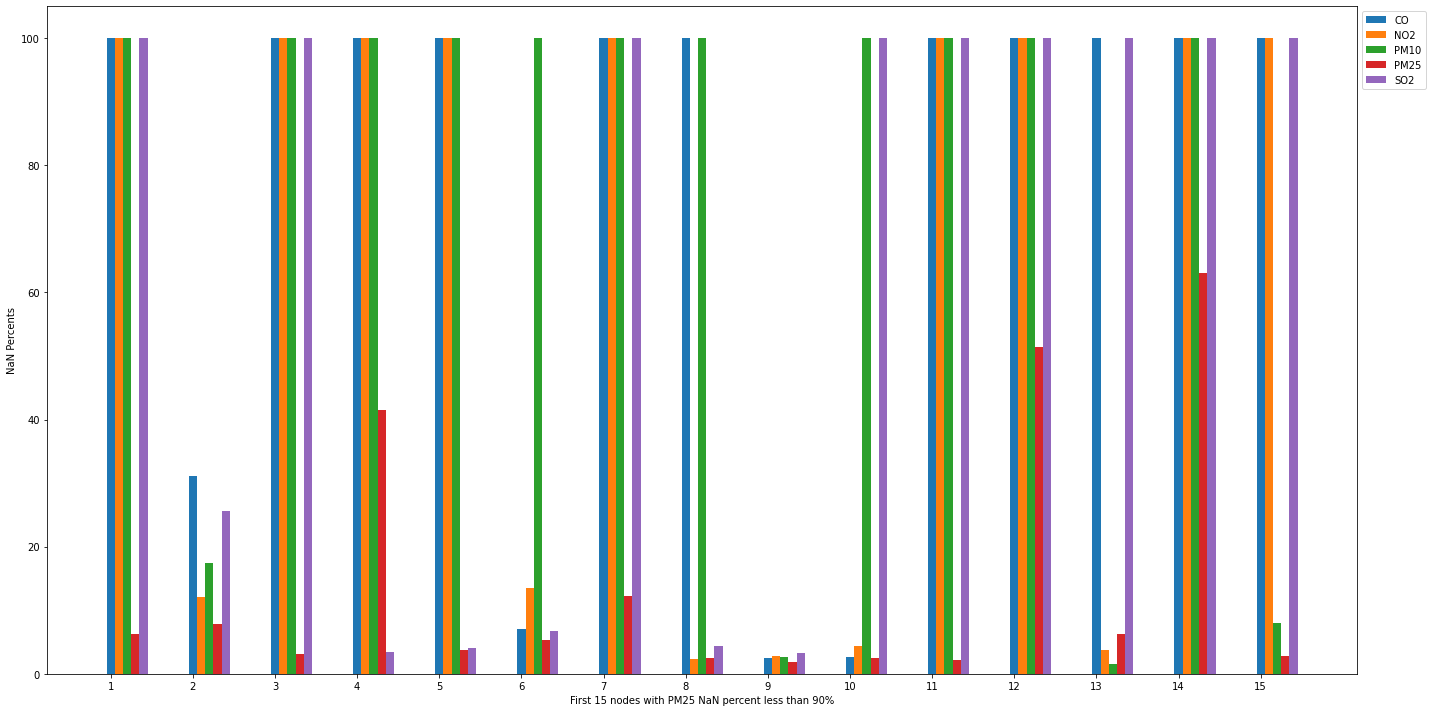

In [108]:
import matplotlib.pyplot as plt
import numpy as np

num = 15

labels = np.arange(1, num+1)

x = np.arange(len(labels))  # the label locations

width = 0.1  # the width of the bars

nans_perc = get_nans_perc(kept_nodes, slice_at = num)

r1 = np.arange(len(nans_perc[0]))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]
r5 = [x + width for x in r4]

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(r1, nans_perc[0], width, label='CO')
rects2 = ax.bar(r2, nans_perc[1], width, label='NO2')
rects3 = ax.bar(r3, nans_perc[2], width, label='PM10')
rects4 = ax.bar(r4, nans_perc[3], width, label='PM25')
rects5 = ax.bar(r5, nans_perc[4], width, label='SO2')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('NaN Percents')
ax.set_xlabel('First 15 nodes with PM25 NaN percent less than 90%')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend(bbox_to_anchor=(1, 1))

fig.tight_layout()

plt.show()

For the reason explained above we decide to keep only PM2.5 as pollutant for our data and subsequent training

Now we plot the distribution of the percent of NaNs only in PM2.5 pollutant for the kept nodes

In [111]:
pm25_perc_all = get_nans_perc(kept_nodes)[3]

Text(0, 0.5, 'Flights')

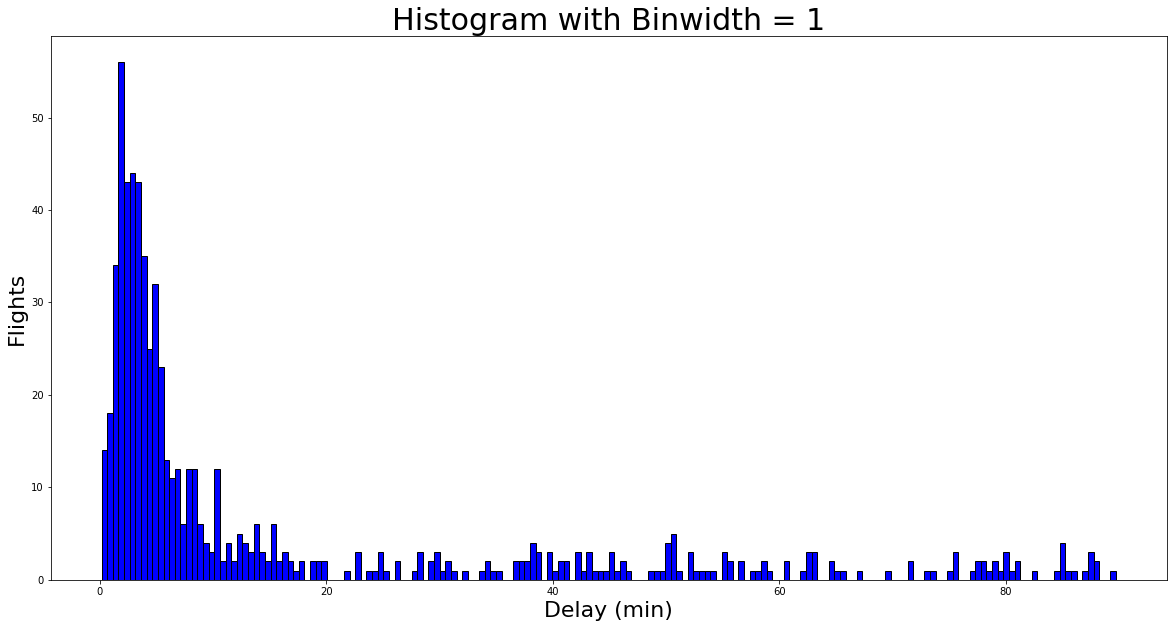

In [112]:

binwidth = 1
fig, ax = plt.subplots(figsize=(20, 10))

ax.hist(pm25_perc_all, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
# Title and labels
ax.set_xlabel('NaNs percent', size = 22)
ax.set_ylabel('Flights', size= 22)

In [3]:

# features = ['CO', 'NO2', 'PM10', 'SO2']

# for feature in range(4):
nodes_to_keep = []

for node in data.columns.get_level_values(0).drop_duplicates():
    keep = node_info(data, node)
    if keep: nodes_to_keep.append(node)

print(f'{len(nodes_to_keep)}')


NameError: name 'node_info' is not defined

In [ ]:
print(f'Keep {len(nodes_to_keep)} on {data.shape[1]//5}')

In [ ]:
from airquality import AirQuality


aq = AirQuality(data_dir='../data')


In [1]:
from temporal_builder import TemporalDataBuilder

tbd = TemporalDataBuilder(data_dir ='../data')

Found temporal data pickle, loading...	DONE!


In [2]:
tbd.nodes_to_keep

['1.0-103.0-11.0',
 '1.0-113.0-3.0',
 '1.0-73.0-23.0',
 '10.0-1.0-2.0',
 '10.0-3.0-1007.0',
 '10.0-3.0-1008.0',
 '10.0-3.0-2004.0',
 '10.0-5.0-1002.0',
 '11.0-1.0-41.0',
 '11.0-1.0-43.0',
 '11.0-1.0-51.0',
 '11.0-1.0-53.0',
 '12.0-1.0-3012.0',
 '12.0-103.0-18.0',
 '12.0-103.0-4.0',
 '12.0-105.0-6006.0',
 '12.0-11.0-2003.0',
 '12.0-11.0-34.0',
 '12.0-11.0-35.0',
 '12.0-11.0-5005.0',
 '12.0-115.0-13.0',
 '12.0-117.0-1002.0',
 '12.0-127.0-5002.0',
 '12.0-31.0-108.0',
 '12.0-31.0-98.0',
 '12.0-33.0-4.0',
 '12.0-57.0-113.0',
 '12.0-57.0-3002.0',
 '12.0-71.0-5.0',
 '12.0-86.0-1016.0',
 '12.0-9.0-7.0',
 '12.0-95.0-2002.0',
 '12.0-99.0-22.0',
 '13.0-135.0-2.0',
 '13.0-139.0-3.0',
 '13.0-153.0-1.0',
 '13.0-21.0-12.0',
 '13.0-245.0-91.0',
 '13.0-295.0-2.0',
 '13.0-303.0-1.0',
 '13.0-51.0-1002.0',
 '13.0-59.0-2.0',
 '13.0-89.0-2.0',
 '13.0-95.0-7.0',
 '15.0-1.0-1006.0',
 '15.0-1.0-1012.0',
 '15.0-1.0-2016.0',
 '15.0-1.0-2020.0',
 '15.0-1.0-2023.0',
 '15.0-1.0-5.0',
 '15.0-3.0-10.0',
 '15.0-3.0-10

In [3]:
sites = tbd.dataset

In [4]:
sites.head()

uniqueid,1.0-103.0-11.0,1.0-113.0-3.0,1.0-73.0-23.0,10.0-1.0-2.0,10.0-3.0-1007.0,10.0-3.0-1008.0,10.0-3.0-2004.0,10.0-5.0-1002.0,11.0-1.0-41.0,11.0-1.0-43.0,...,80.0-2.0-12.0,80.0-2.0-14.0,9.0-1.0-10.0,9.0-1.0-1123.0,9.0-11.0-124.0,9.0-3.0-1003.0,9.0-3.0-25.0,9.0-5.0-5.0,9.0-9.0-2123.0,9.0-9.0-27.0
,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,...,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:00:00,NaN,NaN,NaN,5.4,NaN,10.0,7.2,5.2,10.0,12.0,...,NaN,NaN,11.0,9.0,7.0,6.0,8.0,7.0,0.0,3.0
2018-01-01 06:00:00,NaN,16.0,13.4,5.2,NaN,12.1,5.6,5.2,14.0,11.0,...,NaN,NaN,8.0,9.0,7.0,6.0,10.0,6.0,1.0,3.0
2018-01-01 07:00:00,NaN,15.0,21.1,8.0,NaN,12.8,5.1,5.2,11.0,11.0,...,NaN,NaN,9.0,5.0,6.0,8.0,7.0,5.0,4.0,3.0
2018-01-01 08:00:00,NaN,15.0,17.4,7.7,NaN,12.5,4.8,6.1,16.0,9.0,...,344.0,622.0,8.0,3.0,3.0,7.0,3.0,1.0,3.0,1.0
2018-01-01 09:00:00,NaN,13.0,5.4,7.6,NaN,7.9,4.2,6.0,8.0,10.0,...,292.0,744.0,5.0,4.0,3.0,5.0,3.0,4.0,1.0,0.0


In [5]:
import pandas as pd

In [6]:
nans_df = pd.DataFrame(columns=['node', 'nans_num'])

In [7]:
for i, node in enumerate(sites.columns.get_level_values(0).drop_duplicates()):
    nans_df.loc[i] = [node] + [node_info(sites,node)]


In [9]:
nans_df.dtypes

node        object
nans_num     int64
dtype: object

In [11]:
nans_df.head()

,node,nans_num
0,1.0-103.0-11.0,22639
1,1.0-113.0-3.0,1364
2,1.0-73.0-23.0,1459
3,10.0-1.0-2.0,2600
4,10.0-3.0-1007.0,7290


In [12]:
tbd.nodes_to_keep

['1.0-103.0-11.0',
 '1.0-113.0-3.0',
 '1.0-73.0-23.0',
 '10.0-1.0-2.0',
 '10.0-3.0-1007.0',
 '10.0-3.0-1008.0',
 '10.0-3.0-2004.0',
 '10.0-5.0-1002.0',
 '11.0-1.0-41.0',
 '11.0-1.0-43.0',
 '11.0-1.0-51.0',
 '11.0-1.0-53.0',
 '12.0-1.0-3012.0',
 '12.0-103.0-18.0',
 '12.0-103.0-4.0',
 '12.0-105.0-6006.0',
 '12.0-11.0-2003.0',
 '12.0-11.0-34.0',
 '12.0-11.0-35.0',
 '12.0-11.0-5005.0',
 '12.0-115.0-13.0',
 '12.0-117.0-1002.0',
 '12.0-127.0-5002.0',
 '12.0-31.0-108.0',
 '12.0-31.0-98.0',
 '12.0-33.0-4.0',
 '12.0-57.0-113.0',
 '12.0-57.0-3002.0',
 '12.0-71.0-5.0',
 '12.0-86.0-1016.0',
 '12.0-9.0-7.0',
 '12.0-95.0-2002.0',
 '12.0-99.0-22.0',
 '13.0-135.0-2.0',
 '13.0-139.0-3.0',
 '13.0-153.0-1.0',
 '13.0-21.0-12.0',
 '13.0-245.0-91.0',
 '13.0-295.0-2.0',
 '13.0-303.0-1.0',
 '13.0-51.0-1002.0',
 '13.0-59.0-2.0',
 '13.0-89.0-2.0',
 '13.0-95.0-7.0',
 '15.0-1.0-1006.0',
 '15.0-1.0-1012.0',
 '15.0-1.0-2016.0',
 '15.0-1.0-2020.0',
 '15.0-1.0-2023.0',
 '15.0-1.0-5.0',
 '15.0-3.0-10.0',
 '15.0-3.0-10

In [8]:
from airquality import AirQuality

aq = AirQuality(data_dir='../data')

Found temporal data pickle, loading...	DONE!
Found a valid build, loading... 	DONE!


In [9]:
result = pd.DataFrame(columns=['start_node', 'nans_sum'])

In [10]:
result

,start_node,nans_sum


In [11]:
from tqdm import tqdm

In [12]:
aq.dataset.head()

nodes,1.0-103.0-11.0,1.0-113.0-3.0,1.0-73.0-23.0,10.0-1.0-2.0,10.0-3.0-1007.0,10.0-3.0-1008.0,10.0-3.0-2004.0,10.0-5.0-1002.0,11.0-1.0-41.0,11.0-1.0-43.0,...,80.0-2.0-12.0,80.0-2.0-14.0,9.0-1.0-10.0,9.0-1.0-1123.0,9.0-11.0-124.0,9.0-3.0-1003.0,9.0-3.0-25.0,9.0-5.0-5.0,9.0-9.0-2123.0,9.0-9.0-27.0
channels,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,...,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25,PM25
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:00:00,10.900000,19.142857,11.44,5.4,13.0,10.0,7.2,5.2,10.0,12.0,...,53.166668,116.166664,11.0,9.0,7.0,6.0,8.0,7.0,0.0,3.0
2018-01-01 06:00:00,9.428533,16.000000,13.40,5.2,12.1,12.1,5.6,5.2,14.0,11.0,...,61.833332,137.500000,8.0,9.0,7.0,6.0,10.0,6.0,1.0,3.0
2018-01-01 07:00:00,9.472011,15.000000,21.10,8.0,13.0,12.8,5.1,5.2,11.0,11.0,...,71.500000,141.166672,9.0,5.0,6.0,8.0,7.0,5.0,4.0,3.0
2018-01-01 08:00:00,9.545652,15.000000,17.40,7.7,14.1,12.5,4.8,6.1,16.0,9.0,...,344.000000,622.000000,8.0,3.0,3.0,7.0,3.0,1.0,3.0,1.0
2018-01-01 09:00:00,9.561413,13.000000,5.40,7.6,15.7,7.9,4.2,6.0,8.0,10.0,...,292.000000,744.000000,5.0,4.0,3.0,5.0,3.0,4.0,1.0,0.0


In [13]:
aq.get_closest_nodes(start_node='1.0-103.0-11.0', n_nodes = 50)

[0,
 1,
 2,
 33,
 34,
 35,
 36,
 38,
 39,
 41,
 42,
 43,
 73,
 79,
 111,
 112,
 113,
 115,
 117,
 121,
 123,
 125,
 201,
 202,
 203,
 206,
 207,
 305,
 308,
 429,
 431,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461]

In [14]:

for size in [50,60,70,80,90,100]:
    for i, node in enumerate(tqdm(sites.columns.get_level_values(0).drop_duplicates(), leave=False)):
        neighbours = aq.get_closest_nodes(node, size)
        sum = 0
        for subnode in neighbours:
            subnode = aq.lookup_id(subnode)
            sum+=(nans_df.loc[nans_df['node'] == subnode])['nans_num'].item()
        result.loc[i] = [node] + [sum]
    #print("\r")
    print('Subgraphs of size '+str(size), end ='')
    min_node = result.loc[:, 'nans_sum'].idxmin()
    min = result.loc[:, 'nans_sum'].min()
    print("\t" + aq.lookup_id(min_node), " " + str((min/(size*17526) * 100)) + "% of nan on total nodes")

Subgraphs of size 50	6.0-83.0-2004.0  10.566815017688008% of nan on total nodes


Subgraphs of size 60	6.0-31.0-4.0  10.399977176765947% of nan on total nodes


Subgraphs of size 70	6.0-79.0-8002.0  10.948549909522178% of nan on total nodes


Subgraphs of size 80	15.0-1.0-1006.0  14.284776902887138% of nan on total nodes


Subgraphs of size 90	6.0-31.0-1004.0  16.503353747448234% of nan on total nodes


Subgraphs of size 100	19.0-103.0-2001.0  17.17145954581764% of nan on total nodes


In [87]:
min_node = result.loc[:, 'nans_sum'].idxmin()

In [90]:
min = result.loc[:, 'nans_sum'].min()

In [91]:
min

76499

In [89]:
result.loc[min_node, :]

start_node    6.0-27.0-2.0
nans_sum             76499
Name: 578, dtype: object

In [88]:
aq.lookup_id(min_node)

'6.0-27.0-2.0'

In [2]:
from airquality import AirQuality as AQ
aq = AQ(data_dir='../data')

Found temporal data pickle, loading...	DONE!
Found a valid build, loading... 	DONE!


In [2]:
import pandas as pd

In [4]:
df = pd.read_csv('../data/final2.csv')


In [29]:
df['PM25'].isna().sum()

0

In [5]:
df

,DateTime,State Code,County Code,Site Num,PM25
0,2018-01-01 06:00:00,1,73,23,13.4
1,2018-01-01 07:00:00,1,73,23,21.1
2,2018-01-01 08:00:00,1,73,23,17.4
3,2018-01-01 09:00:00,1,73,23,5.4
4,2018-01-01 10:00:00,1,73,23,5.5
...,...,...,...,...,...
16051099,2021-01-01 03:00:00,80,2,14,47.0
16051100,2021-01-01 04:00:00,80,2,14,133.0
16051101,2021-01-01 05:00:00,80,2,14,65.0
16051102,2021-01-01 06:00:00,80,2,14,92.0


In [7]:
df.insert(1, column='ID', value=None)

In [8]:
df.head()

,DateTime,ID,State Code,County Code,Site Num,PM25
0,2018-01-01 06:00:00,None,1,73,23,13.4
1,2018-01-01 07:00:00,None,1,73,23,21.1
2,2018-01-01 08:00:00,None,1,73,23,17.4
3,2018-01-01 09:00:00,None,1,73,23,5.4
4,2018-01-01 10:00:00,None,1,73,23,5.5


In [9]:
from tqdm import tqdm

In [10]:

curr_id = -1
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_id = str(float(row['State Code'])) + '-' + str(float(row['County Code'])) + '-' + str(float(row['Site Num']))
    if row_id != curr_id:
        curr_id = row_id

    df.at[i, 'ID'] = curr_id

100%|██████████| 16051104/16051104 [16:08<00:00, 16570.13it/s]


In [10]:
df[20000:30000]

,DateTime,ID,State Code,County Code,Site Num,PM25
20000,2018-06-26 01:00:00,2.0-20.0-18.0,2,20,18,2.0
20001,2018-06-26 02:00:00,2.0-20.0-18.0,2,20,18,3.0
20002,2018-06-26 03:00:00,2.0-20.0-18.0,2,20,18,4.0
20003,2018-06-26 04:00:00,2.0-20.0-18.0,2,20,18,5.0
20004,2018-06-26 05:00:00,2.0-20.0-18.0,2,20,18,3.0
...,...,...,...,...,...,...
29995,2018-08-31 21:00:00,2.0-20.0-1004.0,2,20,1004,2.0
29996,2018-08-31 22:00:00,2.0-20.0-1004.0,2,20,1004,4.0
29997,2018-08-31 23:00:00,2.0-20.0-1004.0,2,20,1004,2.0
29998,2018-09-01 00:00:00,2.0-20.0-1004.0,2,20,1004,2.0


In [7]:
ids = list(df.loc[:, 'ID'].drop_duplicates())
ids

KeyError: 'ID'

In [6]:
len(ids)

NameError: name 'ids' is not defined

In [12]:
backup = df.copy()
backup.to_csv('../data/backup.csv', index=False)

In [13]:
df = backup.copy()

In [14]:
df.drop(columns=['State Code', 'Site Num', 'County Code'], inplace=True)

In [19]:
df.head()

,DateTime,ID,PM25,PM25_targ
0,2018-01-01 06:00:00,1.0-73.0-23.0,13.4,None
1,2018-01-01 07:00:00,1.0-73.0-23.0,21.1,None
2,2018-01-01 08:00:00,1.0-73.0-23.0,17.4,None
3,2018-01-01 09:00:00,1.0-73.0-23.0,5.4,None
4,2018-01-01 10:00:00,1.0-73.0-23.0,5.5,None


In [18]:
df.insert(3, column='PM25_targ', value=None)

ValueError: cannot insert PM25_targ, already exists

In [17]:
df.head()

,DateTime,ID,PM25,PM25_targ
0,2018-01-01 06:00:00,1.0-73.0-23.0,13.4,None
1,2018-01-01 07:00:00,1.0-73.0-23.0,21.1,None
2,2018-01-01 08:00:00,1.0-73.0-23.0,17.4,None
3,2018-01-01 09:00:00,1.0-73.0-23.0,5.4,None
4,2018-01-01 10:00:00,1.0-73.0-23.0,5.5,None


In [20]:
final_df = pd.DataFrame(columns=df.columns)
final_df

,DateTime,ID,PM25,PM25_targ


In [21]:
for id in tqdm(ids):

    subdf = df.loc[df['ID'] == str(id)]
    subdf['PM25_targ'] = subdf['PM25'].shift(-1)
    subdf.iloc[-1:, 3] = subdf.iloc[-1:, 2]

    final_df = pd.concat([final_df, subdf])

    


  0%|          | 0/723 [00:00<?, ?it/s]C:\Users\armas\AppData\Local\Temp\ipykernel_11056\4079283519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['PM25_targ'] = subdf['PM25'].shift(-1)
  0%|          | 1/723 [00:01<16:30,  1.37s/it]C:\Users\armas\AppData\Local\Temp\ipykernel_11056\4079283519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['PM25_targ'] = subdf['PM25'].shift(-1)
  0%|          | 2/723 [00:02<11:32,  1.04it/s]C:\Users\armas\AppData\Local\Temp\ipykernel_11056\4079283519.py

In [22]:
final_df

,DateTime,ID,PM25,PM25_targ
0,2018-01-01 06:00:00,1.0-73.0-23.0,13.4,21.1
1,2018-01-01 07:00:00,1.0-73.0-23.0,21.1,17.4
2,2018-01-01 08:00:00,1.0-73.0-23.0,17.4,5.4
3,2018-01-01 09:00:00,1.0-73.0-23.0,5.4,5.5
4,2018-01-01 10:00:00,1.0-73.0-23.0,5.5,15.2
...,...,...,...,...
16034217,2021-01-01 02:00:00,56.0-37.0-23.0,3.0,2.0
16034218,2021-01-01 03:00:00,56.0-37.0-23.0,2.0,1.0
16034219,2021-01-01 04:00:00,56.0-37.0-23.0,1.0,3.0
16034220,2021-01-01 05:00:00,56.0-37.0-23.0,3.0,5.0


In [23]:
final_df.to_csv('../data/backup2.csv', index=False)

In [27]:
final_df['PM25'].isna().sum()

0

In [ ]:
final_df.to_csv('../data/final_lstm.csv', index=False)

In [1]:
import LSTM_data as LD
import pandas as pd
from tqdm import tqdm

In [20]:
df = pd.read_csv('../data/final_lstm.csv')

In [21]:
ids = list(df.loc[:, 'ID'].drop_duplicates())

In [16]:
df['ID'].loc[df['ID'] == ids[0]] = int(0)


C:\Users\armas\AppData\Local\Temp\ipykernel_8176\4005350270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ID'].loc[df['ID'] == ids[0]] = int(0)


In [17]:
df

,DateTime,ID,PM25,PM25_targ
0,2018-01-01 06:00:00,0,13.4,21.1
1,2018-01-01 07:00:00,0,21.1,17.4
2,2018-01-01 08:00:00,0,17.4,5.4
3,2018-01-01 09:00:00,0,5.4,5.5
4,2018-01-01 10:00:00,0,5.5,15.2
...,...,...,...,...
16051099,2021-01-01 02:00:00,56.0-37.0-23.0,3.0,2.0
16051100,2021-01-01 03:00:00,56.0-37.0-23.0,2.0,1.0
16051101,2021-01-01 04:00:00,56.0-37.0-23.0,1.0,3.0
16051102,2021-01-01 05:00:00,56.0-37.0-23.0,3.0,5.0


In [22]:
df['ID'] = df['ID'].astype(str)

for i, id in tqdm(enumerate(ids), total=len(ids)):
    df['ID'].loc[df['ID'] == id] = int(i)


  0%|          | 0/723 [00:00<?, ?it/s]C:\Users\armas\AppData\Local\Temp\ipykernel_8176\1334447745.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ID'].loc[df['ID'] == id] = int(i)
100%|██████████| 723/723 [09:38<00:00,  1.25it/s]


In [23]:
df

,DateTime,ID,PM25,PM25_targ
0,2018-01-01 06:00:00,0,13.4,21.1
1,2018-01-01 07:00:00,0,21.1,17.4
2,2018-01-01 08:00:00,0,17.4,5.4
3,2018-01-01 09:00:00,0,5.4,5.5
4,2018-01-01 10:00:00,0,5.5,15.2
...,...,...,...,...
16051099,2021-01-01 02:00:00,722,3.0,2.0
16051100,2021-01-01 03:00:00,722,2.0,1.0
16051101,2021-01-01 04:00:00,722,1.0,3.0
16051102,2021-01-01 05:00:00,722,3.0,5.0


In [24]:
df.to_csv('../data/final_lstm_ind.csv', index=False)

In [31]:
df

,DateTime,ID,PM25,PM25_targ
0,2018-01-01 06:00:00,0,13.4,21.1
1,2018-01-01 07:00:00,0,21.1,17.4
2,2018-01-01 08:00:00,0,17.4,5.4
3,2018-01-01 09:00:00,0,5.4,5.5
4,2018-01-01 10:00:00,0,5.5,15.2
...,...,...,...,...
16051099,2021-01-01 02:00:00,722,3.0,2.0
16051100,2021-01-01 03:00:00,722,2.0,1.0
16051101,2021-01-01 04:00:00,722,1.0,3.0
16051102,2021-01-01 05:00:00,722,3.0,5.0


In [5]:
df.drop(['DateTime'], axis=1, inplace=True)
df['ID'] = pd.to_numeric(df['ID'])

In [35]:
df.reset_index(drop=True, inplace=True)

In [36]:
df

,ID,PM25,PM25_targ
0,0,13.4,21.1
1,0,21.1,17.4
2,0,17.4,5.4
3,0,5.4,5.5
4,0,5.5,15.2
...,...,...,...
16051099,722,3.0,2.0
16051100,722,2.0,1.0
16051101,722,1.0,3.0
16051102,722,3.0,5.0


In [2]:
import pandas as pd
import LSTM_data as LD

In [3]:
df = pd.read_csv('../data/final_lstm_ind.csv')

In [14]:
ids = list(df.loc[:, 'ID'].drop_duplicates())

min_shape = 25500
nodes_kept = []



for id in ids:
    subdf = df.loc[df['ID'] == id]
    if subdf.shape[0] >= min_shape:
        nodes_kept.append(id)

print(len(nodes_kept))

222


In [16]:
corrected_df = pd.DataFrame(columns=df.columns)

for node in nodes_kept[:200]:
    subdf = (df.loc[df['ID'] == node])[:min_shape]
    corrected_df = pd.concat([corrected_df, subdf])

corrected_df

,ID,PM25,PM25_targ
112718,5,8.0,6.0
112719,5,6.0,10.0
112720,5,10.0,9.0
112721,5,9.0,16.0
112722,5,16.0,9.0
...,...,...,...
14032178,572,5.0,2.0
14032179,572,2.0,1.0
14032180,572,1.0,0.0
14032181,572,0.0,1.0


In [17]:
corrected_df.to_csv('../data/final_lstm_subdim.csv', index=False)

In [1]:
corrected_df = pd.read_csv('../data/final_lstm_subdim.csv')

NameError: name 'pd' is not defined

In [ ]:
corrected_df

,ID,PM25,PM25_targ
0,5,8.0,6.0
1,5,6.0,10.0
2,5,10.0,9.0
3,5,9.0,16.0
4,5,16.0,9.0
...,...,...,...
5099995,572,5.0,2.0
5099996,572,2.0,1.0
5099997,572,1.0,0.0
5099998,572,0.0,1.0


In [1]:
import pandas as pd
import LSTM_data as LD

In [2]:
corrected_df = pd.read_csv('../data/final_lstm_subdim.csv')

corrected_df['ID'] = pd.to_numeric(corrected_df['ID'])
corrected_df['PM25'] = pd.to_numeric(corrected_df['PM25'])
corrected_df['PM25_targ'] = pd.to_numeric(corrected_df['PM25_targ'])

corrected_df.dtypes


ID             int64
PM25         float64
PM25_targ    float64
dtype: object

In [3]:
a, _, _ = LD.prepare_data(corrected_df)

In [6]:
(a[0])

[tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.8986e-04,  3.6232e-05,  1.4493e-04,  1.8116e-04, -1.0870e-04,
           1.8116e-04,  1.0870e-04,  7.2464e-05,  1.4493e-04, -3.6232e-05,
           1.0870e-04,  3.6232e-05,  0.0000e+00,  1.4493e-04,  3.6232e-04,
           5.7971e-04,  3.2609e-04,  2.1739e-04,  1.0870e-04,  3.6232e-05,
           1.0870e-04,  0.0000e+00,  1.4493e-04,  9.0580e-04,  1.4493e-04,
           2.1739e-04,  7.2464e-05,  1.4493e-04,  1.0870e-04,  1.0870e-04,
           2.1739e-04,  2.1739e-04],
         [ 2.1739e-04,  7.

In [11]:
corrected_df[corrected_df['ID'] == 5]

,ID,PM25,PM25_targ
0,5,0.000290,6.0
1,5,0.000217,10.0
2,5,0.000362,9.0
3,5,0.000326,16.0
4,5,0.000580,9.0
...,...,...,...
25495,5,0.000072,4.0
25496,5,0.000145,3.0
25497,5,0.000109,0.0
25498,5,0.000000,0.0


In [5]:
len(a)

200

In [8]:
a[0]

[tensor([ 2.8986e-04,  2.1739e-04,  3.6232e-04,  3.2609e-04,  5.7971e-04,
          3.2609e-04,  4.7102e-04,  2.8986e-04,  1.8116e-04,  1.4493e-04,
          0.0000e+00, -7.2464e-05], device='cuda:0'),
 tensor([-7.2464e-05, -1.0870e-04, -7.2464e-05,  3.6232e-05,  0.0000e+00,
          3.6232e-05,  1.0870e-04,  7.2464e-05,  0.0000e+00,  0.0000e+00,
          3.6232e-05,  0.0000e+00,  0.0000e+00], device='cuda:0'),
 tensor([ 0.0000e+00,  3.6232e-05,  3.6232e-05, -3.6232e-05, -7.2464e-05,
         -3.6232e-05,  0.0000e+00,  3.6232e-05,  3.6232e-05,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  3.6232e-05], device='cuda:0'),
 tensor([ 3.6232e-05,  0.0000e+00,  7.2464e-05,  1.4493e-04,  7.2464e-05,
         -3.6232e-05,  0.0000e+00, -3.6232e-05, -1.0870e-04, -3.6232e-05,
         -3.6232e-05, -3.6232e-05,  0.0000e+00], device='cuda:0'),
 tensor([ 0.0000e+00,  0.0000e+00,  3.6232e-05,  0.0000e+00,  0.0000e+00,
          7.2464e-05,  3.6232e-05,  3.6232e-05,  7.2464e-05,  0.0000e+00,
     

In [19]:
a

[[tensor([ 2.8986e-04,  2.1739e-04,  3.6232e-04,  3.2609e-04,  5.7971e-04,
           3.2609e-04,  4.7102e-04,  2.8986e-04,  1.8116e-04,  1.4493e-04,
           0.0000e+00, -7.2464e-05], device='cuda:0'),
  tensor([-7.2464e-05, -1.0870e-04, -7.2464e-05,  3.6232e-05,  0.0000e+00,
           3.6232e-05,  1.0870e-04,  7.2464e-05,  0.0000e+00,  0.0000e+00,
           3.6232e-05,  0.0000e+00,  0.0000e+00], device='cuda:0'),
  tensor([ 0.0000e+00,  3.6232e-05,  3.6232e-05, -3.6232e-05, -7.2464e-05,
          -3.6232e-05,  0.0000e+00,  3.6232e-05,  3.6232e-05,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  3.6232e-05], device='cuda:0'),
  tensor([ 3.6232e-05,  0.0000e+00,  7.2464e-05,  1.4493e-04,  7.2464e-05,
          -3.6232e-05,  0.0000e+00, -3.6232e-05, -1.0870e-04, -3.6232e-05,
          -3.6232e-05, -3.6232e-05,  0.0000e+00], device='cuda:0'),
  tensor([ 0.0000e+00,  0.0000e+00,  3.6232e-05,  0.0000e+00,  0.0000e+00,
           7.2464e-05,  3.6232e-05,  3.6232e-05,  7.2464e-05,  0.0

In [11]:
from torch.nn.functional import normalize
import torch

In [16]:
working_df = corrected_df.copy()

In [20]:
pm_25_tens = torch.Tensor(working_df['PM25'].values)
working_df['PM25'] = normalize(pm_25_tens, dim=0)
pm_25_y_tens = torch.Tensor(working_df['PM25_targ'].values)
working_df['PM25_targ'] = normalize(pm_25_y_tens, dim=0)

In [21]:
working_df

,ID,PM25,PM25_targ
0,5,0.000290,0.000217
1,5,0.000217,0.000362
2,5,0.000362,0.000326
3,5,0.000326,0.000580
4,5,0.000580,0.000326
...,...,...,...
5099995,572,0.000181,0.000072
5099996,572,0.000072,0.000036
5099997,572,0.000036,0.000000
5099998,572,0.000000,0.000036


In [9]:
from airquality import AirQuality as AQ
import pandas as pd

In [10]:
start_node = '6.0-79.0-8002.0'
sub_size = 70

In [11]:
aq = AQ(data_dir='..\data')
closest_nodes = aq.get_closest_nodes(start_node, sub_size)

Found temporal data pickle, loading...	DONE!
Found a valid build, loading... 	DONE!


In [12]:
df = pd.read_csv('..\data\\backup.csv')

In [13]:
df.head()

,DateTime,ID,State Code,County Code,Site Num,PM25
0,2018-01-01 06:00:00,1.0-73.0-23.0,1,73,23,13.4
1,2018-01-01 07:00:00,1.0-73.0-23.0,1,73,23,21.1
2,2018-01-01 08:00:00,1.0-73.0-23.0,1,73,23,17.4
3,2018-01-01 09:00:00,1.0-73.0-23.0,1,73,23,5.4
4,2018-01-01 10:00:00,1.0-73.0-23.0,1,73,23,5.5


In [14]:
from tqdm import tqdm

In [15]:
ids_ind = closest_nodes
ids_str = []

for ind in ids_ind:
    ids_str.append(aq.lookup_id(ind))

min_shape = 2 ** 10

for id in tqdm(ids_str):
    subdf = df.loc[df['ID'] == id]
    if subdf.shape[0] < min_shape:
        min_shape = subdf.shape[0]
    if subdf.shape[0] == 0:
        print(id)

print(min_shape)

100%|██████████| 70/70 [00:54<00:00,  1.29it/s]

1024


In [16]:
new_df = pd.DataFrame(columns = df.columns)

for id in tqdm(ids_str):
    subdf = df.loc[df['ID'] == id]
    new_df = pd.concat([new_df, subdf])

df.to_csv(f'..\data\\closest{sub_size}_{start_node}.csv')

 93%|█████████▎| 65/70 [00:52<00:04,  1.18it/s]